In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-spam-or-not-classification/spam_dataset.csv


# Config

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
data = pd.read_csv('/kaggle/input/email-spam-or-not-classification/spam_dataset.csv') 

# EDA

In [4]:
data.head()

message_content  is_spam
0  Hello Lonnie,\n\nJust wanted to touch base reg...        0
1  Congratulations, you've won a prize! Call us n...        1
2  You have been pre-approved for a credit card w...        1
3  Limited time offer, act now! Only a few spots ...        1
4  Your loan has been approved! Transfer funds to...        1

In [5]:
data.info()
print('-' * 50)
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_content  1000 non-null   object
 1   is_spam          1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
--------------------------------------------------


message_content    0
is_spam            0
dtype: int64

In [6]:
data['is_spam'].value_counts()

is_spam
0    500
1    500
Name: count, dtype: int64

Text(0.5, 1.0, 'Class Distribution')

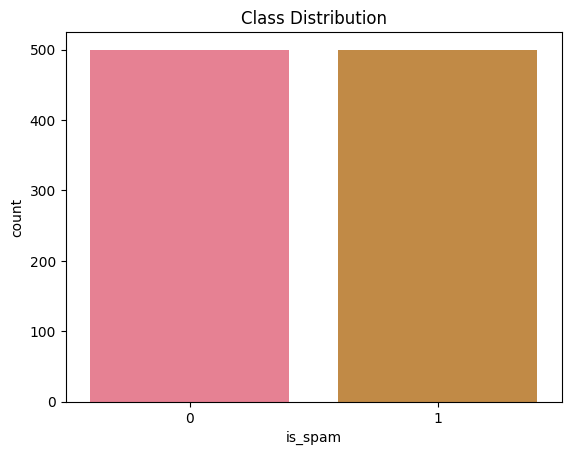

In [7]:
colors = sns.color_palette('husl', 9)

sns.countplot(x='is_spam', data=data, palette=colors)
plt.title('Class Distribution')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Message Length Distribution')

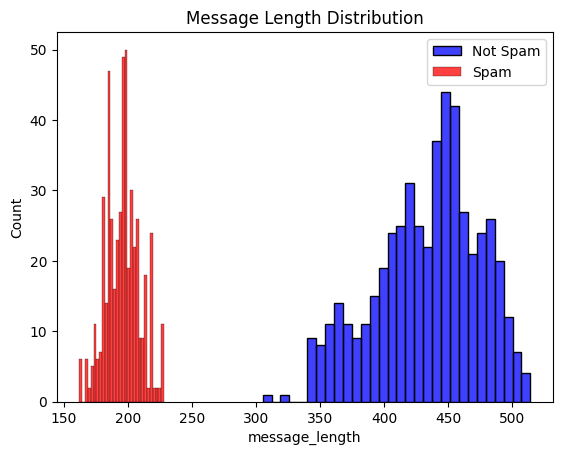

In [8]:
data['message_length'] = data['message_content'].apply(len)
sns.histplot(data[data['is_spam'] == 0]['message_length'], bins=30, color='blue', label='Not Spam')
sns.histplot(data[data['is_spam'] == 1]['message_length'], bins=30, color='red', label='Spam')
plt.legend()
plt.title('Message Length Distribution')

In [9]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text: str) -> str:
    # Convert words to lowercarse
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W',' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove short words (less than 3 letters)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Stemming
    text = ' '.join(stemmer.stem(word) for word in text.split())
    
    return text
        
    
data['cleaned_message'] = data['message_content'].apply(preprocess_text)

In [10]:
data[['message_content', 'cleaned_message']].head()

message_content  \
0  Hello Lonnie,\n\nJust wanted to touch base reg...   
1  Congratulations, you've won a prize! Call us n...   
2  You have been pre-approved for a credit card w...   
3  Limited time offer, act now! Only a few spots ...   
4  Your loan has been approved! Transfer funds to...   

                                     cleaned_message  
0  hello lonni want touch base regard project nex...  
1  congratul prize call claim account select spec...  
2  pre approv credit card high limit special offe...  
3  limit time offer act spot left immedi action r...  
4  loan approv transfer fund today hurri lifetim ...

In [11]:
data['message_length'] = data['cleaned_message'].apply(len)
sns.histplot(data[data['is_spam'] == 0]['message_length'], bins=30, color='green', label='Not Spam')
sns.histplot(data[data['is_spam'] == 1]['message_length'], bins=30, color='purple', label='Spam')
plt.legend()
plt.title('Message length distribution after NORMALIZATION')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Message length distribution after NORMALIZATION')

# Training

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['cleaned_message']).toarray()
y = data['is_spam'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spame', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()